In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from quant_free.dataset.us_equity_load import *
from quant_free.utils.us_equity_utils import *
from quant_free.factor.price import *
from quant_free.finml.cross_validation.cross_validation import PurgedKFold, cross_val_score
from quant_free.finml.feature_importance.importance import *


from quant_free.finml.utils.multiprocess import mp_pandas_obj

symbol = 'TSM'
# symbol = 'AAPL'
# symbol = 'INTC'

# factor_name = 'Trend.csv'
# like1 = 'trend'
# like2 = 'ret_backward_'

factor_name = 'Alpha101.csv'
like1 = 'alpha'
like2 = 'ret_backward_'

thr = 0.00
forward_period = 5
start_date = get_json_config_value("start_date")
end_date = get_json_config_value("end_date")

factor = us_equity_data_load_within_range(symbols = [symbol], start_date = start_date,
                                end_date = end_date, column_option = "all", file_name = factor_name)[symbol]
factor = factor.replace({True: 1, False: 0})
factor = factor.loc[:, (factor != 0).any(axis=0)]
filtered_1 = factor.filter(like=like1)
filtered_2 = factor.filter(like=like2)
# cols_to_keep = [col for col in filtered_2.columns if not any(int(s) >= forward_period for s in col.split('_') if s.isdigit())]
# filtered_2 = filtered_2[cols_to_keep]
factor_filter = pd.concat([filtered_1, filtered_2], axis=1)
trnsX = factor_filter.astype(np.float64)

# price_ratio = PriceRatio(start_date, end_date, symbol = symbol, column_option = 'close', dir_option = 'xq')
# y_data = price_ratio.price_ratio(periods = periods)
y_data = factor.loc[:, f'ret_forward_{forward_period}']
cont = pd.DataFrame(y_data.map(lambda x: 1 if x > thr else 0 if x < -thr else 0))
cont = pd.concat([cont, y_data], axis = 1)
cont.columns = ['bin', f'price_ratio_{forward_period}']
cont['t1'] = cont.index
print(cont.tail(10))

factor_filter_summary = []
top_number = 10


def factor_collect(factors_importance, top_number, factor_filter_summary):
    factors_importance.sort_values('mean', ascending=True, inplace=True)
    top_factors = factors_importance.head(top_number)
    factor_filter_summary.extend(top_factors.index)
    print("factor len:", len(factor_filter_summary))
    factor_filter_summary = list(set(factor_filter_summary))
    return factor_filter_summary
    
cv_gen = PurgedKFold(
    n_splits = 20, 
    samples_info_sets = cont['t1']
)

            bin  price_ratio_5         t1
2024-09-23    0      -0.006257 2024-09-23
2024-09-24    0      -0.055941 2024-09-24
2024-09-25    0      -0.036581 2024-09-25
2024-09-26    0      -0.040136 2024-09-26
2024-09-27    1       0.017766 2024-09-27
2024-09-30    1       0.017766 2024-09-30
2024-10-01    1       0.017766 2024-10-01
2024-10-02    1       0.017766 2024-10-02
2024-10-03    1       0.017766 2024-10-03
2024-10-04    1       0.017766 2024-10-04


In [2]:
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

ols = sm.Logit(cont['bin'], trnsX).fit()
# ols.pvalues.sort_values

Optimization terminated successfully.
         Current function value: 0.437322
         Iterations 10


In [3]:
factor_filter_summary = list(set(factor_filter_summary))
factor_filter_summary.extend(ols.pvalues[ols.pvalues < 0.05].index.tolist())
factor_filter_summary.pop(0)
print("factor len:", len(factor_filter_summary))

factor len: 14


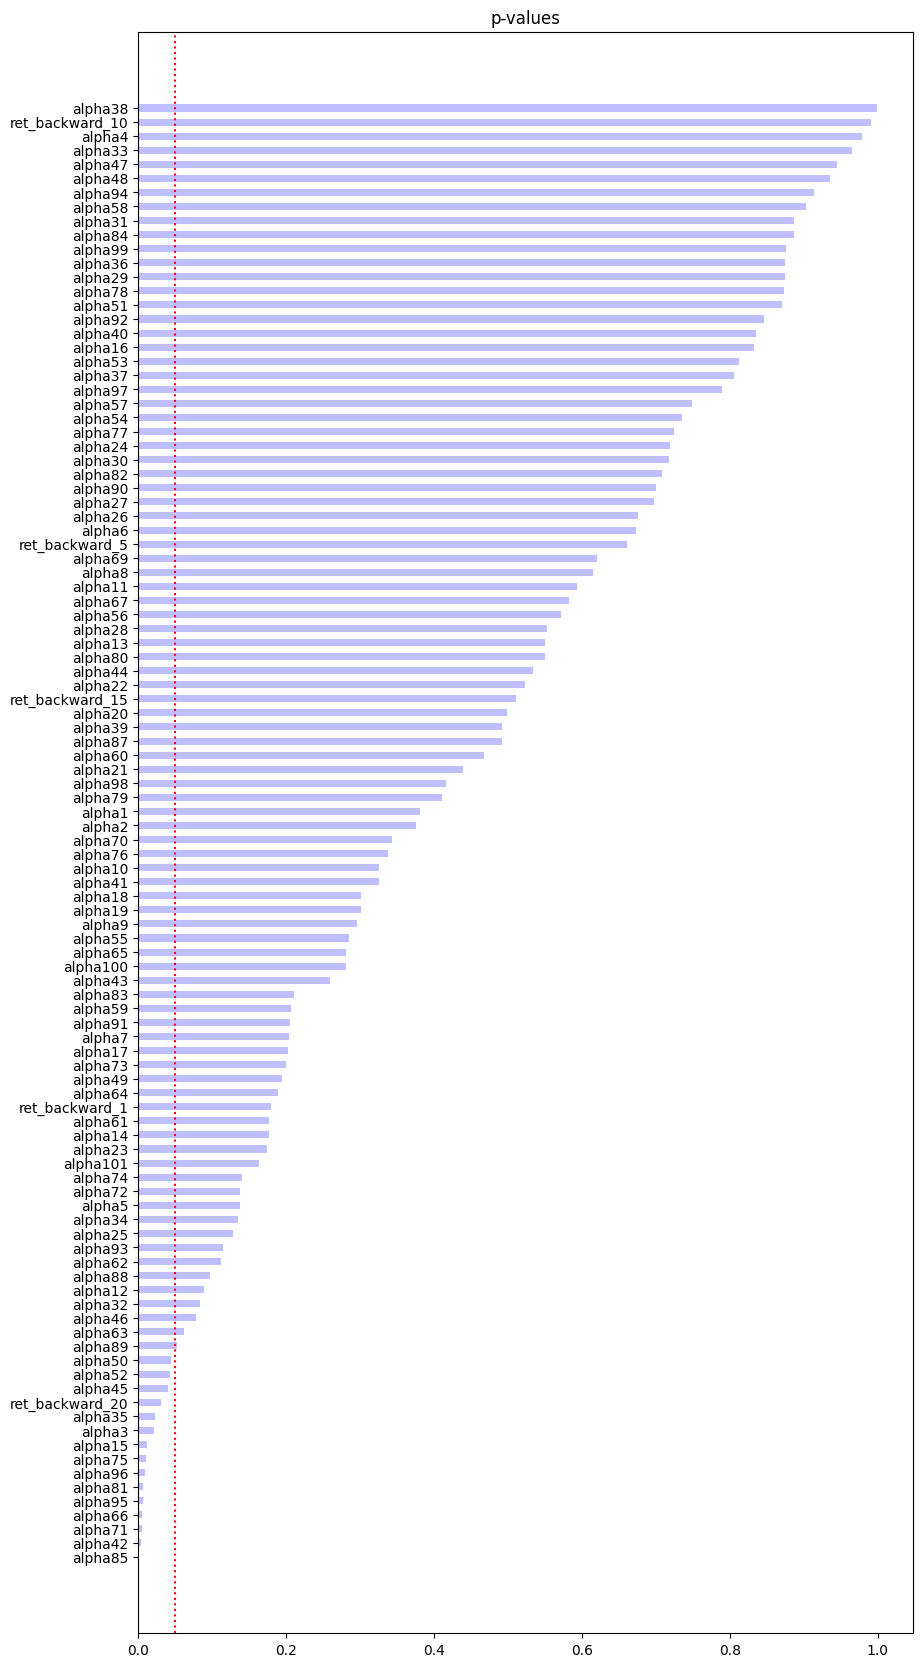

In [4]:
plt.figure(figsize=(10, len(ols.pvalues) * 0.20))
plt.barh(
    ols.pvalues.sort_values(ascending = True).index, 
    ols.pvalues.sort_values(ascending = True), 
    color = 'b', alpha = 0.25, height = 0.5
)

plt.axvline(0.05, ls = ':', color = 'r')
plt.grid(False)
plt.title('p-values')
plt.show()

In [5]:
from sklearn.ensemble import RandomForestClassifier
from quant_free.finml.feature_importance import *

forest = RandomForestClassifier(
    criterion = 'entropy',
    class_weight = 'balanced_subsample',
    min_weight_fraction_leaf = 0.0,
    random_state = 42,
    n_estimators = 100,
    max_features = 1,
    oob_score = True,
    n_jobs = 1
)

# fit = forest.fit(X = trnsX, y = cont['bin'])
# oob_score = fit.oob_score_
# print(f"oob_score {oob_score}")

from quant_free.finml.cross_validation.cross_validation import PurgedKFold, cross_val_score
from quant_free.finml.feature_importance.importance import *
cv_gen = PurgedKFold(
    n_splits = 20, 
    samples_info_sets = cont['t1']
)

def compute_feature_importance(clf, X, y, cv_gen, molecule):
    scoring = log_loss
    sample_weight = None
    
    factor_ = X.loc[:, molecule]
    sfi = single_feature_importance(
        clf, # base classification model
        factor_, # train features
        cont['bin'], # train labels
        cv_gen, # purged k fold cross validation class
        scoring = accuracy_score
    )
    
    return sfi

In [6]:
def single_feature_importance_parallel(clf, X, y, cv_gen, scoring = log_loss, sample_weight = None):
    feature_names = X.columns
    if sample_weight is None:
        sample_weight = np.ones((X.shape[0],))

    num_threads=8
    imp = mp_pandas_obj(
                        func = compute_feature_importance,
                        pd_obj = ('molecule', feature_names),
                        num_threads =num_threads,
                        clf = clf,
                        X = X,
                        y = y,
                        cv_gen = cv_gen
                        )
    # imp = imp.set_index('index')
    return imp

sfi = single_feature_importance_parallel(
    forest, # base classification model
    factor_filter, # train features
    cont, # train labels
    cv_gen, # purged k fold cross validation class
    scoring = accuracy_score
)

  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [03:05<00:00, 14.29s/it]e_importance done after 2.97 minutes. Remaining 0.42 minutes.
2025-02-22 12:13:14.008097 100.0% compute_feature_importance done after 3.1 minutes. Remaining 0.0 minutes.


In [7]:
factor_filter_summary = factor_collect(sfi, top_number, factor_filter_summary)

factor len: 24


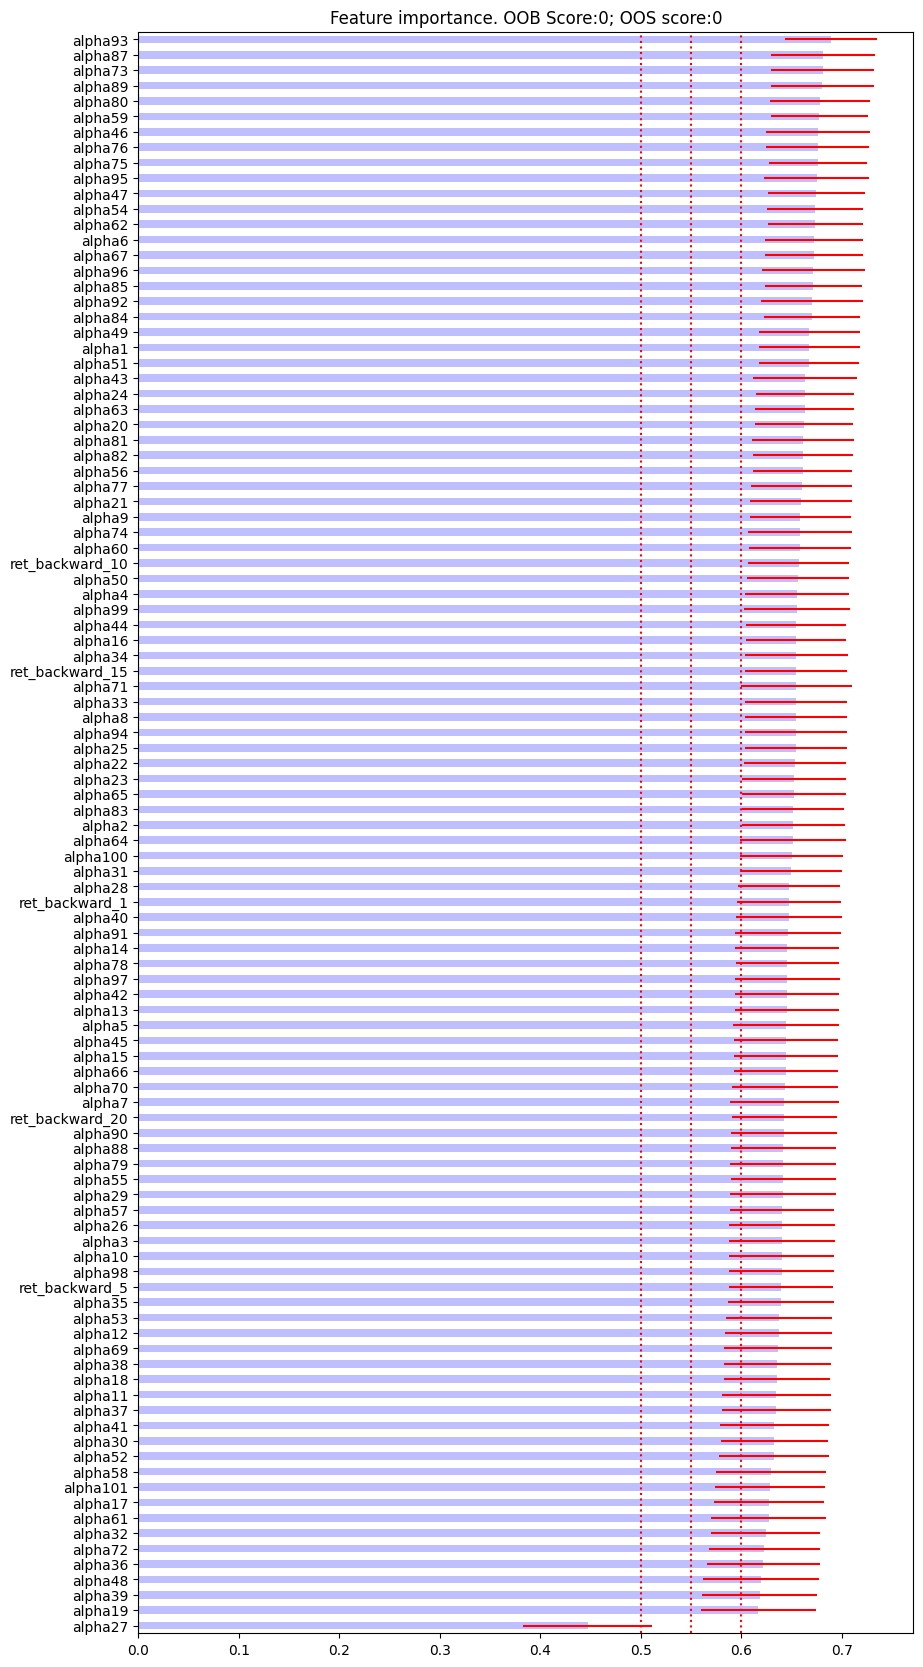

In [8]:
plot_feature_importance(
    sfi,
    oob_score = 0,
    oos_score = 0,
    save_fig = True,
    output_path = f'./research/finML/factor_analysis/images/{symbol}_{like1}_SFI_feature_importance.png'
)
plt.axvline(0.5, ls = ':', color = 'r')
plt.axvline(0.55, ls = ':', color = 'r')
plt.axvline(0.6, ls = ':', color = 'r')
plt.grid(False)
plt.show()

In [9]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from quant_free.finml.feature_importance import *

forest = RandomForestClassifier(
    # criterion = 'entropy',
    criterion = 'gini',
    class_weight = 'balanced_subsample',
    min_weight_fraction_leaf = 0.0,
    random_state = 42,
    n_estimators = 1000,
    max_features = 1,
    oob_score = True,
    n_jobs = 1
)

fit = forest.fit(X = trnsX, y = cont['bin'])
oob_score = fit.oob_score_


oos_score = cross_val_score(
    forest, # base classifier
    trnsX, # train features
    cont['bin'], # train labels
    cv_gen = cv_gen, # purged k fold cross validation class
    scoring = accuracy_score # optimizing to accuracy score
).mean()

mdi = mean_decrease_impurity(fit, trnsX.columns)

In [10]:
factor_filter_summary = factor_collect(mdi, top_number, factor_filter_summary)
print((factor_filter_summary))

factor len: 34
['alpha64', 'alpha45', 'alpha96', 'alpha19', 'alpha61', 'alpha62', 'alpha48', 'ret_backward_20', 'alpha39', 'alpha3', 'alpha75', 'alpha32', 'alpha21', 'alpha71', 'alpha42', 'alpha99', 'alpha35', 'alpha65', 'alpha72', 'alpha50', 'alpha17', 'alpha27', 'alpha66', 'alpha36', 'alpha95', 'alpha79', 'alpha85', 'alpha74', 'alpha52', 'alpha101', 'alpha81']


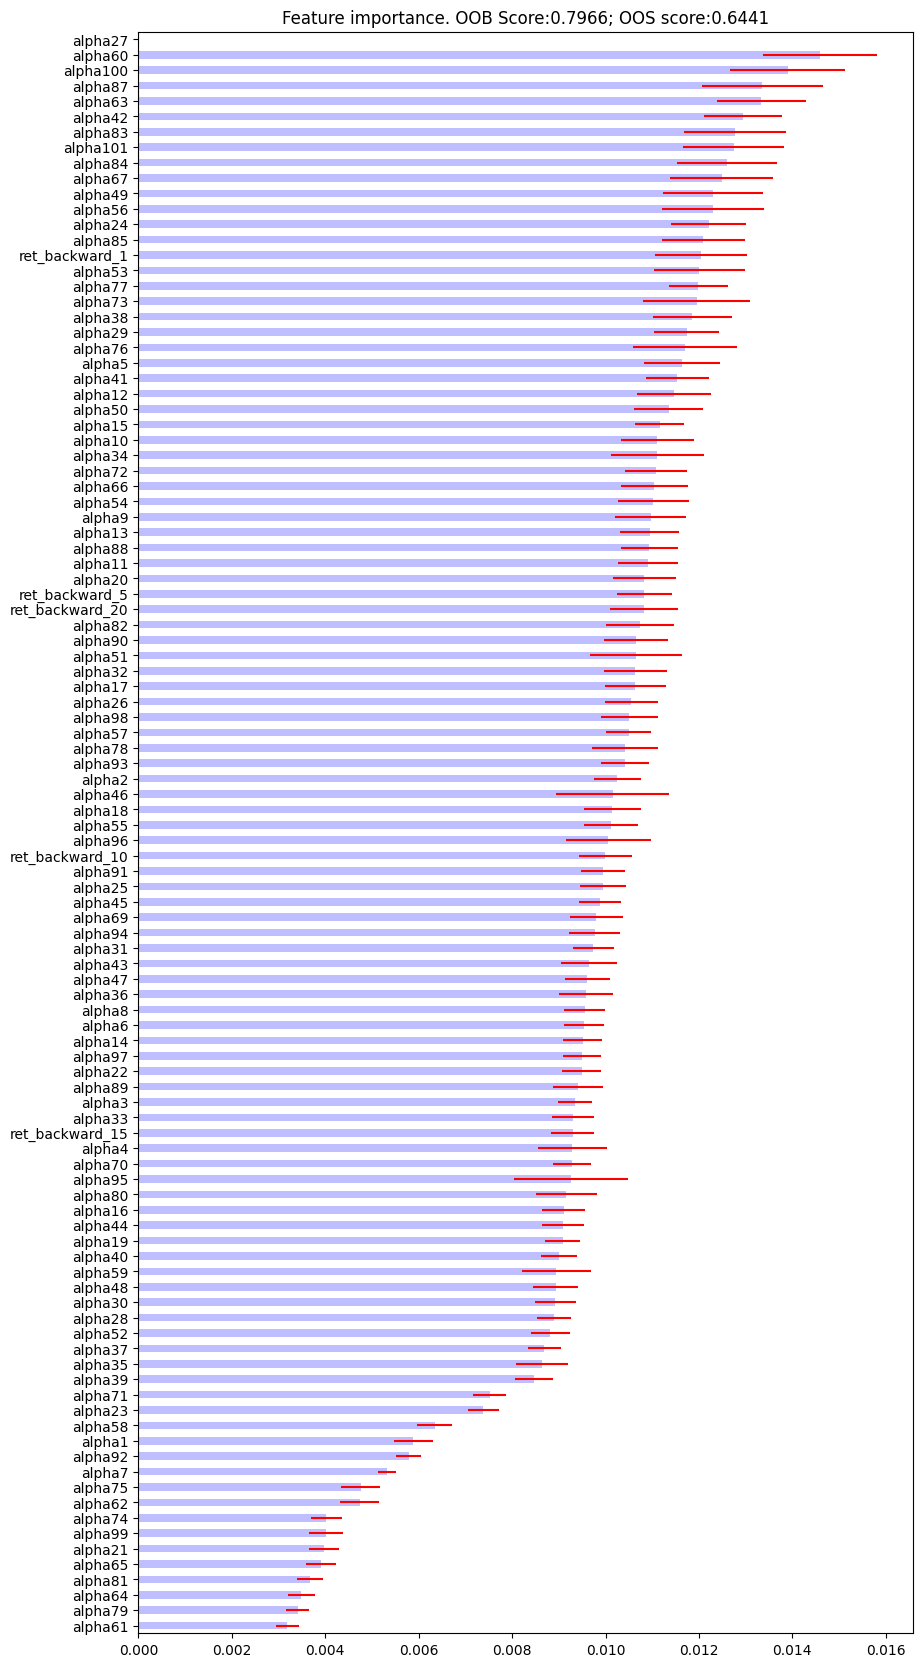

In [11]:
plot_feature_importance(
    mdi,
    oob_score = oob_score,
    oos_score = oos_score,
    save_fig = True,
    output_path = f'./research/finML/factor_analysis/images/{symbol}_{like1}_MDI_feature_importance.png'
)
plt.grid(False)
plt.show()

In [12]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from quant_free.finml.feature_importance import *
forest = RandomForestClassifier(
    # criterion = 'gini',
    # criterion = 'entropy',
    criterion = 'log_loss',
    class_weight = 'balanced_subsample',
    min_weight_fraction_leaf = 0.0,
    random_state = 42,
    n_estimators = 1000,
    max_features = 1,
    oob_score = True,
    n_jobs = 1
)

fit = forest.fit(X = trnsX, y = cont['bin'])
oob_score = fit.oob_score_

oos_score = cross_val_score(
    forest, # base classifier
    trnsX, # train features
    cont['bin'], # train labels
    cv_gen = cv_gen, # purged k fold cross validation class
    scoring = accuracy_score # optimizing to accuracy score
).mean()

In [13]:
mda = mean_decrease_accuracy(
    fit, # base classification model
    trnsX, # train features
    cont['bin'], # train labels
    cv_gen, # purged k fold cross validation class
    scoring = accuracy_score
)

mda.sort_values('mean', ascending=False).head()

20it [02:31,  7.59s/it]


,mean,std
alpha45,0.021187,0.010655
alpha79,0.017469,0.00923
alpha50,0.015119,0.007442
alpha8,0.014544,0.011747
alpha83,0.013339,0.006694


In [14]:
factor_filter_summary = factor_collect(mda, top_number, factor_filter_summary)
print((factor_filter_summary))

factor len: 41
['alpha64', 'alpha45', 'alpha96', 'alpha94', 'alpha19', 'alpha100', 'alpha61', 'alpha62', 'alpha48', 'alpha6', 'ret_backward_20', 'alpha39', 'alpha80', 'alpha3', 'alpha75', 'alpha32', 'alpha21', 'alpha71', 'alpha42', 'alpha99', 'alpha35', 'alpha65', 'alpha72', 'alpha50', 'alpha31', 'alpha17', 'alpha27', 'alpha66', 'alpha36', 'alpha55', 'alpha95', 'alpha79', 'alpha85', 'alpha74', 'alpha52', 'alpha51', 'alpha101', 'alpha81']


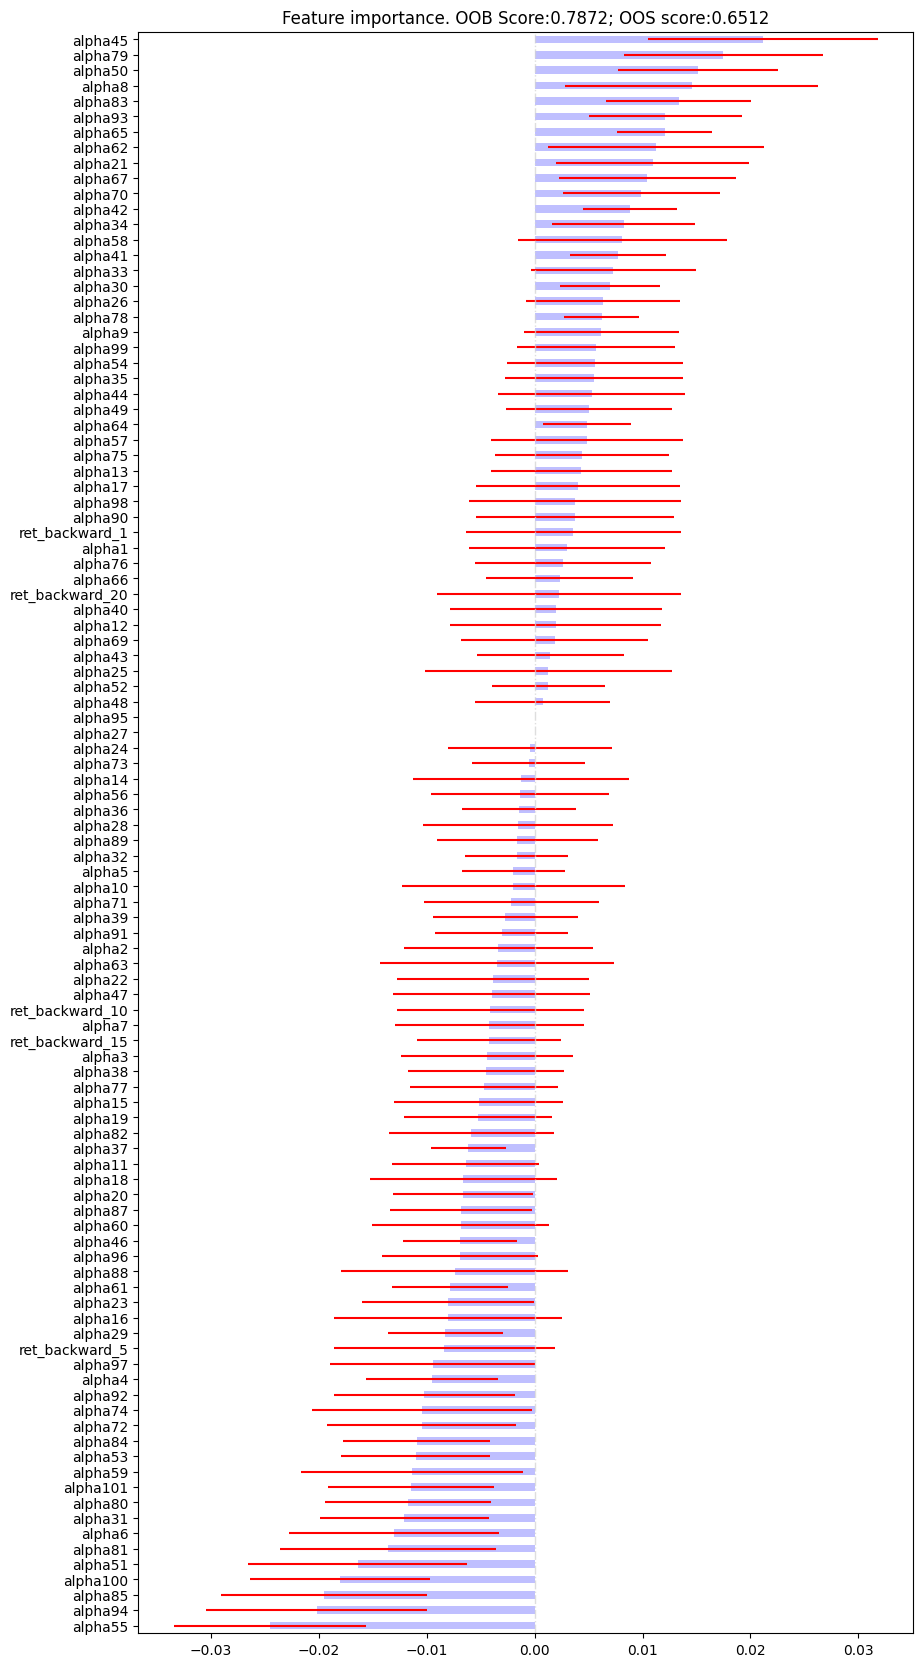

In [15]:
plot_feature_importance(
    mda,
    oob_score = oob_score,
    oos_score = oos_score,
    save_fig = True,
    output_path = f'./research/finML/factor_analysis/images/{symbol}_{like1}_MDA_feature_importance.png'
)
plt.grid(False)
plt.show()

In [16]:
from sklearn.ensemble import RandomForestClassifier
from quant_free.finml.cross_validation.cross_validation import PurgedKFold, cross_val_score


forest = RandomForestClassifier(
    criterion = 'log_loss',
    class_weight = 'balanced_subsample',
    min_weight_fraction_leaf = 0.0,
    random_state = 42,
    n_estimators = 1000,
    max_features = 1,
    oob_score = True,
    n_jobs = 10
)

# factor_filter_summary = ['trend_divergence_5', 'trend_energy_30', 'trend_adx_10', 'trend_intensity_15', 'trend_price_acc_30', 'trend_stochastic_25', 'trend_intensity_5', 'trend_alpha_mom_25', 'trend_breakout_10', 'trend_breakout_20', 'trend_energy_10', 'trend_alpha_mom_20', 'trend_ewma_15', 'trend_stochastic_10', 'trend_divergence_30', 'trend_energy_15', 'trend_time_trend_25', 'trend_divergence_15', 'trend_ewma_20', 'trend_alpha_mom_10', 'trend_intensity_20', 'trend_ewma_10', 'trend_triple_ewma_diff_5', 'trend_divergence_20', 'trend_triple_ewma_diff_30', 'trend_snr_10', 'ret_backward_10', 'trend_intensity_25', 'trend_breakout_15', 'trend_mw_diff_20', 'trend_breakout_5', 'trend_divergence_25', 'trend_alpha_mom_30', 'trend_mw_diff_30', 'trend_snr_5', 'trend_stochastic_15', 'trend_adx_15', 'trend_rsi_10', 'trend_price_mom_30', 'trend_divergence_10', 'trend_time_trend_30', 'trend_price_mom_10']


factor_importance = trnsX.loc[:,factor_filter_summary]
fit = forest.fit(X = factor_importance, y = cont['bin'])
oob_score = fit.oob_score_

cv_gen = PurgedKFold(
    n_splits = 20, 
    samples_info_sets = cont['t1']
)

oos_score = cross_val_score(
    forest, # base classifier
    factor_importance, # train features
    cont['bin'], # train labels
    cv_gen = cv_gen, # purged k fold cross validation class
    scoring = accuracy_score # optimizing to accuracy score
).mean()


print(f"oob_score: {oob_score}, oos_score: {oos_score}")

oob_score: 0.8083480305702528, oos_score: 0.6529411764705882


In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [1000],
    'max_depth': [5, 10, 20],
    'min_samples_split': [3, 5],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': ['auto', 'sqrt']
}

grid_search = GridSearchCV(forest, param_grid, cv=cv_gen)
grid_search.fit(factor_importance, cont['bin'])
print("Best params:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 1000}
Best score: 0.6788235294117646


In [17]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(
    criterion = 'entropy',
    class_weight = 'balanced_subsample',
    min_weight_fraction_leaf = 0.0,
    random_state = 42,
    n_estimators = 1000,
    max_features = 1,
    oob_score = True,
    n_jobs = 1
)

fit = forest.fit(X = trnsX, y = cont['bin'])
oob_score = fit.oob_score_

In [14]:
import shap

forest_explain = shap.TreeExplainer(fit)
shap_values_train = forest_explain(trnsX)

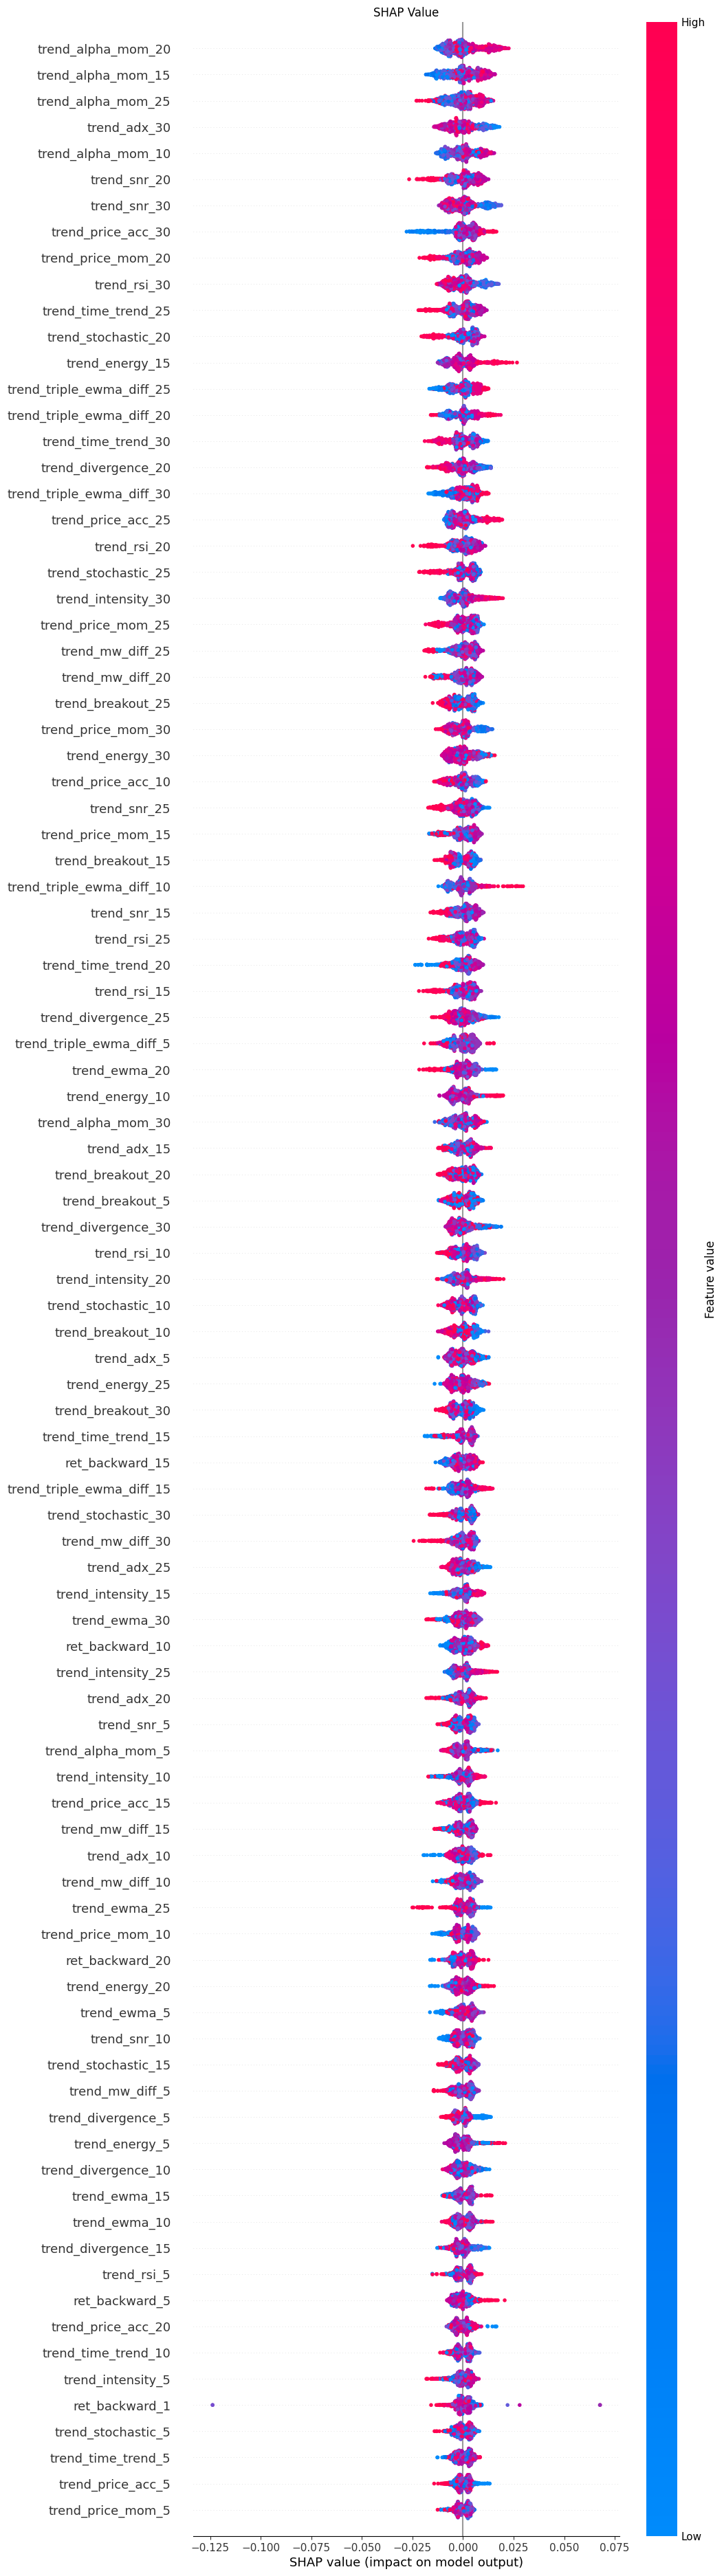

In [18]:
import matplotlib.pyplot as plt
plt.grid(False)
plt.title('SHAP Value')
shap.plots.beeswarm(
    shap_values_train[:,:,1], 
    max_display = len(shap_values_train.feature_names),
    plot_size = (10, shap_values_train.shape[1] * 0.5)
)

plt.show()

In [15]:
import shap
explainer = shap.TreeExplainer(fit)
shap_values = explainer.shap_values(trnsX)

<Figure size 1200x8000 with 0 Axes>

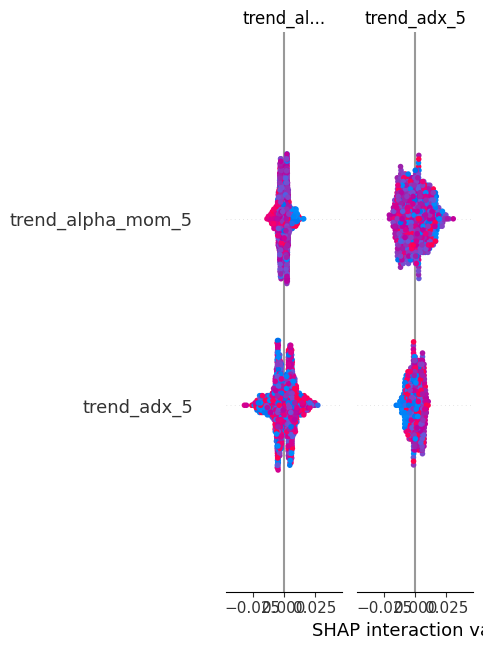

In [19]:
import matplotlib.pyplot as plt
# import shap

plt.figure(figsize=(12, 80))  # Adjust size as needed
shap.summary_plot(shap_values, trnsX, show=False)
plt.tight_layout()  # Automatically adjusts subplot params
plt.show()